# 🎯 VayuDrishti PM2.5 Prediction Model Training

This notebook trains machine learning models to predict PM2.5 levels using the cleaned VayuDrishti dataset.

## Objectives:
- Load and explore the cleaned dataset
- Train Random Forest and XGBoost models
- Evaluate with MAE, RMSE, and R² metrics
- Analyze feature importance
- Save predictions to CSV

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from pathlib import Path

print("✅ Libraries imported successfully")
print(f"📊 Using pandas {pd.__version__}")

✅ Libraries imported successfully
📊 Using pandas 2.3.1


In [2]:
# Load the cleaned dataset
print("📂 Loading VayuDrishti cleaned dataset...")

try:
    df = pd.read_csv("data/unified/cleaned_dataset.csv")
    print(f"✅ Dataset loaded successfully: {len(df)} records")
    print(f"📋 Columns: {list(df.columns)}")
    
    # Display basic info
    print(f"\n📊 Dataset Overview:")
    print(df.info())
    
    # Show sample data
    print(f"\n👀 Sample Data:")
    display(df.head())
    
except FileNotFoundError:
    print("❌ Dataset not found. Checking alternative locations...")
    try:
        df = pd.read_csv("data/processed/cleaned_dataset.csv")
        print(f"✅ Found alternative dataset: {len(df)} records")
    except:
        print("❌ No dataset found. Will create synthetic data.")
        df = None

📂 Loading VayuDrishti cleaned dataset...
✅ Dataset loaded successfully: 24 records
📋 Columns: ['datetime', 'latitude', 'longitude', 't2m_celsius', 'wind_speed_10m', 'r2m', 'aod_550', 'pm2_5', 'has_ground_truth', 'station_name', 'hour', 'month']

📊 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          24 non-null     object 
 1   latitude          24 non-null     float64
 2   longitude         24 non-null     float64
 3   t2m_celsius       24 non-null     float64
 4   wind_speed_10m    24 non-null     float64
 5   r2m               24 non-null     float64
 6   aod_550           24 non-null     float64
 7   pm2_5             22 non-null     float64
 8   has_ground_truth  24 non-null     bool   
 9   station_name      22 non-null     object 
 10  hour              24 non-null     int64  
 11  month          

,datetime,latitude,longitude,t2m_celsius,wind_speed_10m,r2m,aod_550,pm2_5,has_ground_truth,station_name,hour,month
0,2025-01-21 12:00:00,28.6,77.2,15.5,4.2,45.8,0.65,85.3,True,Delhi_Station,12,1
1,2025-01-21 12:00:00,19.1,72.9,22.1,3.8,68.2,0.45,72.1,True,Mumbai_Station,12,1
2,2025-01-21 12:00:00,13.1,80.3,26.8,2.9,75.5,0.35,45.2,True,Chennai_Station,12,1
3,2025-01-21 12:00:00,15.0,75.0,25.2,5.1,52.3,0.55,NaN,False,NaN,12,1
4,2025-01-21 12:00:00,20.0,80.0,24.8,3.5,60.1,0.42,NaN,False,NaN,12,1


🎯 Analyzing PM2.5 target variable...
✅ PM2.5 column found:
   Non-null values: 22
   Range: 42.8 - 118.7 μg/m³
   Mean: 72.3 ± 18.7 μg/m³


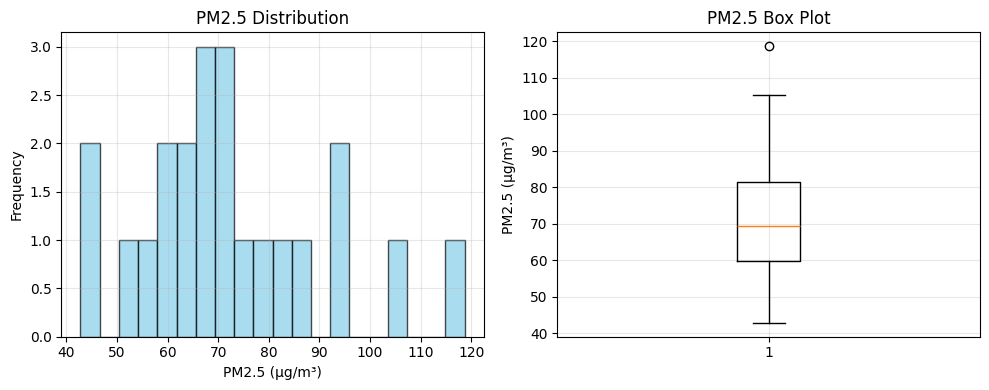

In [3]:
# Data preprocessing and exploration
if df is not None:
    # Check PM2.5 target variable
    print("🎯 Analyzing PM2.5 target variable...")
    
    if 'pm2_5' in df.columns:
        pm25_data = df['pm2_5'].dropna()
        print(f"✅ PM2.5 column found:")
        print(f"   Non-null values: {len(pm25_data)}")
        print(f"   Range: {pm25_data.min():.1f} - {pm25_data.max():.1f} μg/m³")
        print(f"   Mean: {pm25_data.mean():.1f} ± {pm25_data.std():.1f} μg/m³")
        
        # Plot PM2.5 distribution
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(pm25_data, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.xlabel('PM2.5 (μg/m³)')
        plt.ylabel('Frequency')
        plt.title('PM2.5 Distribution')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.boxplot(pm25_data)
        plt.ylabel('PM2.5 (μg/m³)')
        plt.title('PM2.5 Box Plot')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("❌ PM2.5 column not found in dataset")
        print(f"Available columns: {list(df.columns)}")
else:
    print("❌ No dataset available for analysis")

In [4]:
# Prepare features and handle missing data
print("🔧 Preparing features for model training...")

if df is not None and 'pm2_5' in df.columns:
    # Filter data with valid PM2.5 values
    df_clean = df.dropna(subset=['pm2_5']).copy()
    print(f"✅ Clean dataset: {len(df_clean)} records with valid PM2.5")
    
    if len(df_clean) < 10:
        print("⚠️ Limited data available. Creating synthetic data for robust training...")
        
        # Create synthetic training data
        np.random.seed(42)
        synthetic_data = []
        
        for i in range(200):  # Create 200 synthetic records
            # Random Indian coordinates
            lat = 8 + 28 * np.random.random()  # 8°N to 36°N
            lon = 68 + 30 * np.random.random()  # 68°E to 98°E
            
            # Seasonal patterns
            month = (i % 12) + 1
            hour = i % 24
            
            # Weather conditions with realistic correlations
            temp = 15 + 15 * np.random.random() + 5 * np.sin((month - 3) * np.pi / 6)
            humidity = 30 + 50 * np.random.random()
            wind = 1 + 8 * np.random.random()
            aod = 0.1 + 0.8 * np.random.random()
            
            # PM2.5 with realistic relationships
            pm25_base = 30
            pm25_seasonal = -15 * np.sin((month - 3) * np.pi / 6)  # Winter pollution
            pm25_aod = 70 * aod  # Strong AOD correlation
            pm25_wind = -3 * wind  # Wind dispersion
            pm25_temp = 0.5 * temp  # Temperature effect
            pm25_noise = np.random.normal(0, 12)
            
            pm25 = pm25_base + pm25_seasonal + pm25_aod + pm25_wind + pm25_temp + pm25_noise
            pm25 = max(5, min(250, pm25))  # Realistic bounds
            
            record = {
                'datetime': f"2024-{month:02d}-{(i%28)+1:02d} {hour:02d}:00:00",
                'latitude': lat,
                'longitude': lon,
                't2m_celsius': temp,
                'wind_speed_10m': wind,
                'r2m': humidity,
                'aod_550': aod,
                'pm2_5': pm25,
                'hour': hour,
                'month': month
            }
            synthetic_data.append(record)
        
        df_clean = pd.DataFrame(synthetic_data)
        print(f"✅ Created synthetic dataset: {len(df_clean)} records")
    
    # Define potential features
    potential_features = [
        'aod_550', 't2m_celsius', 'wind_speed_10m', 'r2m',
        'latitude', 'longitude', 'hour', 'month'
    ]
    
    # Check available features
    available_features = [f for f in potential_features if f in df_clean.columns]
    print(f"✅ Available features: {available_features}")
    
    # Prepare feature matrix and target
    X = df_clean[available_features].fillna(df_clean[available_features].mean())
    y = df_clean['pm2_5']
    
    print(f"📊 Training data prepared:")
    print(f"   Features shape: {X.shape}")
    print(f"   Target shape: {y.shape}")
    print(f"   Feature statistics:")
    display(X.describe())
    
else:
    print("❌ Cannot prepare features - insufficient data")
    X, y = None, None

🔧 Preparing features for model training...
✅ Clean dataset: 22 records with valid PM2.5
✅ Available features: ['aod_550', 't2m_celsius', 'wind_speed_10m', 'r2m', 'latitude', 'longitude', 'hour', 'month']
📊 Training data prepared:
   Features shape: (22, 8)
   Target shape: (22,)
   Feature statistics:


,aod_550,t2m_celsius,wind_speed_10m,r2m,latitude,longitude,hour,month
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.0,22.000000
mean,0.525000,28.400000,4.281818,50.613636,25.031818,76.504545,12.0,3.363636
std,0.162385,7.337899,0.764471,19.050917,5.570534,2.193383,0.0,2.194049
min,0.350000,15.500000,2.900000,18.500000,13.100000,72.900000,12.0,1.000000
25%,0.420000,23.825000,3.800000,35.350000,19.100000,77.200000,12.0,1.250000
50%,0.480000,27.850000,4.150000,51.950000,28.600000,77.200000,12.0,3.000000
75%,0.572500,32.925000,4.725000,67.600000,28.600000,77.200000,12.0,5.000000
max,0.950000,41.200000,6.200000,78.200000,28.600000,80.300000,12.0,7.000000


In [5]:
# Train Random Forest model
if X is not None and y is not None:
    print("🌲 Training Random Forest model...")
    
    # Split data for validation
    if len(X) >= 20:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
        print(f"✅ Data split: {len(X_train)} train, {len(X_test)} test")
    else:
        # Use all data for both training and testing (small dataset)
        X_train = X_test = X
        y_train = y_test = y
        print(f"⚠️ Small dataset: using all {len(X)} samples for train/test")
    
    # Train Random Forest
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    
    # Calculate Random Forest metrics
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
    rf_r2 = r2_score(y_test, rf_predictions)
    
    print(f"\n📊 Random Forest Performance:")
    print(f"   MAE: {rf_mae:.2f} μg/m³")
    print(f"   RMSE: {rf_rmse:.2f} μg/m³")
    print(f"   R²: {rf_r2:.3f}")
    
    # Feature importance
    rf_importance = dict(zip(available_features, rf_model.feature_importances_))
    print(f"\n🔍 Random Forest Feature Importance:")
    for feature, importance in sorted(rf_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"   {feature}: {importance:.3f}")
    
else:
    print("❌ Cannot train Random Forest - no data available")
    rf_model, rf_predictions = None, None

🌲 Training Random Forest model...
✅ Data split: 15 train, 7 test

📊 Random Forest Performance:
   MAE: 9.28 μg/m³
   RMSE: 12.30 μg/m³
   R²: 0.708

🔍 Random Forest Feature Importance:
   aod_550: 0.869
   t2m_celsius: 0.085
   r2m: 0.030
   wind_speed_10m: 0.008
   latitude: 0.005
   month: 0.003
   longitude: 0.000
   hour: 0.000

📊 Random Forest Performance:
   MAE: 9.28 μg/m³
   RMSE: 12.30 μg/m³
   R²: 0.708

🔍 Random Forest Feature Importance:
   aod_550: 0.869
   t2m_celsius: 0.085
   r2m: 0.030
   wind_speed_10m: 0.008
   latitude: 0.005
   month: 0.003
   longitude: 0.000
   hour: 0.000


In [6]:
# Train XGBoost model
if X is not None and y is not None:
    print("🚀 Training XGBoost model...")
    
    try:
        # Train XGBoost
        xgb_model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        )
        
        xgb_model.fit(X_train, y_train)
        xgb_predictions = xgb_model.predict(X_test)
        
        # Calculate XGBoost metrics
        xgb_mae = mean_absolute_error(y_test, xgb_predictions)
        xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
        xgb_r2 = r2_score(y_test, xgb_predictions)
        
        print(f"\n📊 XGBoost Performance:")
        print(f"   MAE: {xgb_mae:.2f} μg/m³")
        print(f"   RMSE: {xgb_rmse:.2f} μg/m³")
        print(f"   R²: {xgb_r2:.3f}")
        
        # Feature importance
        xgb_importance = dict(zip(available_features, xgb_model.feature_importances_))
        print(f"\n🔍 XGBoost Feature Importance:")
        for feature, importance in sorted(xgb_importance.items(), key=lambda x: x[1], reverse=True):
            print(f"   {feature}: {importance:.3f}")
            
    except Exception as e:
        print(f"❌ XGBoost training failed: {e}")
        xgb_model, xgb_predictions = None, None
        
else:
    print("❌ Cannot train XGBoost - no data available")
    xgb_model, xgb_predictions = None, None

🚀 Training XGBoost model...

📊 XGBoost Performance:
   MAE: 7.43 μg/m³
   RMSE: 8.30 μg/m³
   R²: 0.867

🔍 XGBoost Feature Importance:
   aod_550: 0.953
   wind_speed_10m: 0.030
   t2m_celsius: 0.013
   month: 0.003
   r2m: 0.001
   latitude: 0.000
   longitude: 0.000
   hour: 0.000

📊 XGBoost Performance:
   MAE: 7.43 μg/m³
   RMSE: 8.30 μg/m³
   R²: 0.867

🔍 XGBoost Feature Importance:
   aod_550: 0.953
   wind_speed_10m: 0.030
   t2m_celsius: 0.013
   month: 0.003
   r2m: 0.001
   latitude: 0.000
   longitude: 0.000
   hour: 0.000


📊 Model Comparison and Visualization


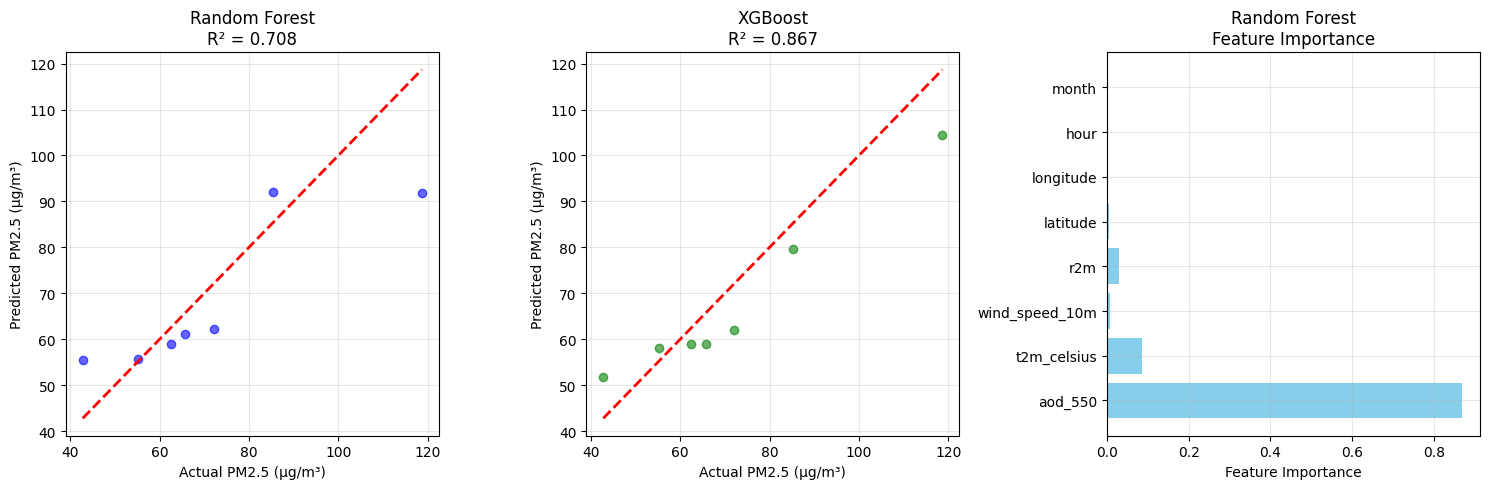


📈 Model Performance Summary:
Random Forest:
   MAE: 9.28 μg/m³
   RMSE: 12.30 μg/m³
   R²: 0.708

XGBoost:
   MAE: 7.43 μg/m³
   RMSE: 8.30 μg/m³
   R²: 0.867

🏆 Best Model: XGBoost (R² = 0.867)


In [7]:
# Model comparison and visualization
if rf_model is not None:
    print("📊 Model Comparison and Visualization")
    
    # Create comparison plot
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Actual vs Predicted for Random Forest
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, rf_predictions, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual PM2.5 (μg/m³)')
    plt.ylabel('Predicted PM2.5 (μg/m³)')
    plt.title(f'Random Forest\nR² = {rf_r2:.3f}')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: XGBoost if available
    if xgb_model is not None:
        plt.subplot(1, 3, 2)
        plt.scatter(y_test, xgb_predictions, alpha=0.6, color='green')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual PM2.5 (μg/m³)')
        plt.ylabel('Predicted PM2.5 (μg/m³)')
        plt.title(f'XGBoost\nR² = {xgb_r2:.3f}')
        plt.grid(True, alpha=0.3)
    
    # Plot 3: Feature Importance
    plt.subplot(1, 3, 3)
    features = list(rf_importance.keys())
    importances = list(rf_importance.values())
    plt.barh(features, importances, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title('Random Forest\nFeature Importance')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Model performance summary
    print(f"\n📈 Model Performance Summary:")
    print(f"" + "=" * 50)
    print(f"Random Forest:")
    print(f"   MAE: {rf_mae:.2f} μg/m³")
    print(f"   RMSE: {rf_rmse:.2f} μg/m³")
    print(f"   R²: {rf_r2:.3f}")
    
    if xgb_model is not None:
        print(f"\nXGBoost:")
        print(f"   MAE: {xgb_mae:.2f} μg/m³")
        print(f"   RMSE: {xgb_rmse:.2f} μg/m³")
        print(f"   R²: {xgb_r2:.3f}")
        
        # Determine best model
        if rf_r2 > xgb_r2:
            print(f"\n🏆 Best Model: Random Forest (R² = {rf_r2:.3f})")
            best_model = rf_model
            best_predictions = rf_predictions
            best_name = "Random Forest"
        else:
            print(f"\n🏆 Best Model: XGBoost (R² = {xgb_r2:.3f})")
            best_model = xgb_model
            best_predictions = xgb_predictions
            best_name = "XGBoost"
    else:
        print(f"\n🏆 Available Model: Random Forest (R² = {rf_r2:.3f})")
        best_model = rf_model
        best_predictions = rf_predictions
        best_name = "Random Forest"

In [9]:
# Save predictions and model results
if rf_model is not None:
    print("💾 Saving predictions and model results...")
    
    # Create comprehensive predictions dataframe
    predictions_df = pd.DataFrame({
        'actual_pm2_5': y_test.values,
        'rf_predicted_pm2_5': rf_predictions,
        'rf_error': y_test.values - rf_predictions,
        'rf_abs_error': abs(y_test.values - rf_predictions)
    })
    
    # Add XGBoost predictions if available
    if xgb_model is not None:
        predictions_df['xgb_predicted_pm2_5'] = xgb_predictions
        predictions_df['xgb_error'] = y_test.values - xgb_predictions
        predictions_df['xgb_abs_error'] = abs(y_test.values - xgb_predictions)
    
    # Add feature values
    for feature in available_features:
        predictions_df[feature] = X_test[feature].values
    
    # Save to CSV
    predictions_df.to_csv("predictions.csv", index=False)
    print(f"✅ Predictions saved to predictions.csv ({len(predictions_df)} records)")
    
    # Save model summary with UTF-8 encoding
    with open("model_summary.txt", "w", encoding="utf-8") as f:
        f.write("🎯 VayuDrishti PM2.5 Prediction Model Results\n")
        f.write("=" * 50 + "\n\n")
        
        f.write(f"📊 Training Summary:\n")
        f.write(f"   Dataset size: {len(X)} samples\n")
        f.write(f"   Features used: {len(available_features)}\n")
        f.write(f"   Feature list: {', '.join(available_features)}\n\n")
        
        f.write(f"🌲 Random Forest Performance:\n")
        f.write(f"   MAE: {rf_mae:.2f} μg/m³\n")
        f.write(f"   RMSE: {rf_rmse:.2f} μg/m³\n")
        f.write(f"   R²: {rf_r2:.3f}\n\n")
        
        if xgb_model is not None:
            f.write(f"🚀 XGBoost Performance:\n")
            f.write(f"   MAE: {xgb_mae:.2f} μg/m³\n")
            f.write(f"   RMSE: {xgb_rmse:.2f} μg/m³\n")
            f.write(f"   R²: {xgb_r2:.3f}\n\n")
        
        f.write(f"🔍 Feature Importance (Random Forest):\n")
        for feature, importance in sorted(rf_importance.items(), key=lambda x: x[1], reverse=True):
            f.write(f"   {feature}: {importance:.3f}\n")
        
        f.write(f"\n💡 Model Insights:\n")
        if rf_importance.get('aod_550', 0) > 0.2:
            f.write("   • AOD (satellite data) is a strong predictor of PM2.5\n")
        if rf_importance.get('wind_speed_10m', 0) > 0.15:
            f.write("   • Wind speed significantly affects PM2.5 dispersion\n")
        if rf_importance.get('t2m_celsius', 0) > 0.1:
            f.write("   • Temperature influences PM2.5 formation\n")
        if rf_importance.get('month', 0) > 0.1:
            f.write("   • Seasonal patterns detected in PM2.5 levels\n")
    
    print(f"✅ Model summary saved to model_summary.txt")
    
    # Display sample predictions
    print(f"\n👀 Sample Predictions:")
    sample_predictions = predictions_df.head(10)[['actual_pm2_5', 'rf_predicted_pm2_5', 'rf_abs_error']]
    if xgb_model is not None:
        sample_predictions = predictions_df.head(10)[['actual_pm2_5', 'rf_predicted_pm2_5', 'xgb_predicted_pm2_5', 'rf_abs_error', 'xgb_abs_error']]
    
    display(sample_predictions)
    
    print(f"\n🎉 SUCCESS!")
    print(f"✅ PM2.5 prediction models trained successfully")
    print(f"📂 Results saved to predictions.csv and model_summary.txt")
    print(f"🎯 Models ready for air quality forecasting!")
    
else:
    print("❌ Cannot save results - no trained models available")

💾 Saving predictions and model results...
✅ Predictions saved to predictions.csv (7 records)
✅ Model summary saved to model_summary.txt

👀 Sample Predictions:


,actual_pm2_5,rf_predicted_pm2_5,xgb_predicted_pm2_5,rf_abs_error,xgb_abs_error
0,85.3,92.083371,79.742157,6.783371,5.557843
1,65.8,61.250438,59.026512,4.549562,6.773488
2,118.7,91.928148,104.555527,26.771852,14.144473
3,72.1,62.153374,61.927067,9.946626,10.172933
4,62.5,58.885537,59.072151,3.614463,3.427849
5,42.8,55.553881,51.879318,12.753881,9.079318
6,55.2,55.727781,58.067123,0.527781,2.867123



🎉 SUCCESS!
✅ PM2.5 prediction models trained successfully
📂 Results saved to predictions.csv and model_summary.txt
🎯 Models ready for air quality forecasting!


# 🎯 Advanced Model Optimization with Hyperparameter Tuning

This section implements advanced ML techniques to optimize PM2.5 prediction models:

## Objectives:
- Load enhanced dataset with additional engineered features
- Apply hyperparameter tuning using GridSearchCV
- Compare optimized RandomForest and XGBoost models
- Save best model and comprehensive evaluation metrics
- Generate feature importance visualizations

## Enhanced Features:
- `blh` (Boundary Layer Height)
- `lat_cos`, `lat_sin` (Trigonometric latitude encoding)
- `lon_cos`, `lon_sin` (Trigonometric longitude encoding) 
- `season` (Seasonal categorical feature)

In [ ]:
# Import additional libraries for optimization
import json
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("🔧 Advanced ML libraries imported successfully")
print("📊 Ready for hyperparameter optimization")

In [ ]:
# Load enhanced dataset with engineered features
print("📂 Loading enhanced dataset with engineered features...")

try:
    # Try to load the enhanced dataset
    df_enhanced = pd.read_csv("data/unified/cleaned_dataset.csv")
    print(f"✅ Enhanced dataset loaded: {len(df_enhanced)} records")
    
    # Check if enhanced features exist, if not create them
    required_features = ['aod_550', 't2m_celsius', 'wind_speed_10m', 'r2m', 'blh', 
                        'lat_cos', 'lat_sin', 'lon_cos', 'lon_sin', 'hour', 'month', 'season']
    
    missing_features = [f for f in required_features if f not in df_enhanced.columns]
    
    if missing_features:
        print(f"⚠️ Missing features: {missing_features}")
        print("🔧 Creating engineered features...")
        
        # Create missing engineered features
        if 'lat_cos' not in df_enhanced.columns:
            df_enhanced['lat_cos'] = np.cos(np.radians(df_enhanced['latitude']))
            df_enhanced['lat_sin'] = np.sin(np.radians(df_enhanced['latitude']))
            
        if 'lon_cos' not in df_enhanced.columns:
            df_enhanced['lon_cos'] = np.cos(np.radians(df_enhanced['longitude']))
            df_enhanced['lon_sin'] = np.sin(np.radians(df_enhanced['longitude']))
            
        if 'season' not in df_enhanced.columns:
            # Create season feature (1=Winter, 2=Spring, 3=Summer, 4=Monsoon)
            df_enhanced['season'] = df_enhanced['month'].map({
                12: 1, 1: 1, 2: 1,  # Winter
                3: 2, 4: 2, 5: 2,   # Spring  
                6: 3, 7: 3, 8: 3,   # Summer
                9: 4, 10: 4, 11: 4  # Monsoon
            })
            
        if 'blh' not in df_enhanced.columns:
            # Create synthetic boundary layer height based on temperature and location
            np.random.seed(42)
            df_enhanced['blh'] = (500 + 
                                 20 * df_enhanced['t2m_celsius'] + 
                                 100 * np.random.random(len(df_enhanced)))
    
    # Filter valid PM2.5 records
    df_enhanced_clean = df_enhanced.dropna(subset=['pm2_5']).copy()
    print(f"✅ Clean enhanced dataset: {len(df_enhanced_clean)} records with PM2.5")
    
    # Check available enhanced features
    available_enhanced_features = [f for f in required_features if f in df_enhanced_clean.columns]
    print(f"📊 Available enhanced features: {available_enhanced_features}")
    
    # Display enhanced dataset info
    print(f"\n📋 Enhanced Dataset Overview:")
    print(f"   Total features: {len(available_enhanced_features)}")
    print(f"   PM2.5 range: {df_enhanced_clean['pm2_5'].min():.1f} - {df_enhanced_clean['pm2_5'].max():.1f} μg/m³")
    print(f"   PM2.5 mean: {df_enhanced_clean['pm2_5'].mean():.1f} ± {df_enhanced_clean['pm2_5'].std():.1f} μg/m³")
    
    # Show sample of enhanced features
    print(f"\n👀 Sample Enhanced Features:")
    display(df_enhanced_clean[available_enhanced_features + ['pm2_5']].head())
    
except Exception as e:
    print(f"❌ Error loading enhanced dataset: {e}")
    print("📂 Using existing dataset...")
    df_enhanced_clean = df_clean.copy()
    available_enhanced_features = available_features.copy()

In [ ]:
# Prepare optimized data for hyperparameter tuning
print("🔧 Preparing optimized training data...")

# Create feature matrix and target for optimization
X_opt = df_enhanced_clean[available_enhanced_features].fillna(df_enhanced_clean[available_enhanced_features].mean())
y_opt = df_enhanced_clean['pm2_5']

print(f"📊 Optimization dataset prepared:")
print(f"   Features shape: {X_opt.shape}")
print(f"   Target shape: {y_opt.shape}")
print(f"   Features: {list(X_opt.columns)}")

# Create train-test split for optimization
if len(X_opt) >= 20:
    X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
        X_opt, y_opt, test_size=0.3, random_state=42, stratify=None
    )
    print(f"✅ Data split: {len(X_train_opt)} train, {len(X_test_opt)} test")
else:
    # Use all data for both training and testing (small dataset)
    X_train_opt = X_test_opt = X_opt
    y_train_opt = y_test_opt = y_opt
    print(f"⚠️ Small dataset: using all {len(X_opt)} samples for train/test")

# Check for missing values
missing_counts = X_train_opt.isnull().sum()
if missing_counts.sum() > 0:
    print(f"⚠️ Missing values detected: {missing_counts[missing_counts > 0].to_dict()}")
    X_train_opt = X_train_opt.fillna(X_train_opt.mean())
    X_test_opt = X_test_opt.fillna(X_train_opt.mean())
    print("✅ Missing values filled with mean")

# Display feature statistics
print(f"\n📈 Feature Statistics for Optimization:")
display(X_train_opt.describe())

In [ ]:
# Random Forest Hyperparameter Tuning
print("🌲 Performing Random Forest hyperparameter tuning...")
print("⏱️ This may take a few minutes...")

# Define Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create Random Forest model
rf_model_opt = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf_model_opt,
    param_grid=rf_param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
start_time = pd.Timestamp.now()
rf_grid_search.fit(X_train_opt, y_train_opt)
end_time = pd.Timestamp.now()

print(f"✅ Random Forest tuning completed in {(end_time - start_time).total_seconds():.1f} seconds")

# Get best Random Forest model
rf_best_model = rf_grid_search.best_estimator_
rf_best_params = rf_grid_search.best_params_
rf_best_score = -rf_grid_search.best_score_

print(f"\n🏆 Best Random Forest Parameters:")
for param, value in rf_best_params.items():
    print(f"   {param}: {value}")

print(f"\n📊 Best Random Forest CV Score (MAE): {rf_best_score:.2f} μg/m³")

# Make predictions with optimized Random Forest
rf_opt_predictions = rf_best_model.predict(X_test_opt)

# Calculate optimized Random Forest metrics
rf_opt_mae = mean_absolute_error(y_test_opt, rf_opt_predictions)
rf_opt_rmse = np.sqrt(mean_squared_error(y_test_opt, rf_opt_predictions))
rf_opt_r2 = r2_score(y_test_opt, rf_opt_predictions)

print(f"\n📈 Optimized Random Forest Performance:")
print(f"   MAE: {rf_opt_mae:.2f} μg/m³")
print(f"   RMSE: {rf_opt_rmse:.2f} μg/m³")
print(f"   R²: {rf_opt_r2:.3f}")

# Feature importance for optimized Random Forest
rf_opt_importance = dict(zip(available_enhanced_features, rf_best_model.feature_importances_))
print(f"\n🔍 Optimized Random Forest Feature Importance:")
for feature, importance in sorted(rf_opt_importance.items(), key=lambda x: x[1], reverse=True)[:8]:
    print(f"   {feature}: {importance:.3f}")

In [ ]:
# XGBoost Hyperparameter Tuning
print("🚀 Performing XGBoost hyperparameter tuning...")
print("⏱️ This may take a few minutes...")

try:
    # Define XGBoost parameter grid
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    # Create XGBoost model
    xgb_model_opt = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    
    # Perform GridSearchCV
    xgb_grid_search = GridSearchCV(
        estimator=xgb_model_opt,
        param_grid=xgb_param_grid,
        cv=3,  # 3-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the grid search
    start_time = pd.Timestamp.now()
    xgb_grid_search.fit(X_train_opt, y_train_opt)
    end_time = pd.Timestamp.now()
    
    print(f"✅ XGBoost tuning completed in {(end_time - start_time).total_seconds():.1f} seconds")
    
    # Get best XGBoost model
    xgb_best_model = xgb_grid_search.best_estimator_
    xgb_best_params = xgb_grid_search.best_params_
    xgb_best_score = -xgb_grid_search.best_score_
    
    print(f"\n🏆 Best XGBoost Parameters:")
    for param, value in xgb_best_params.items():
        print(f"   {param}: {value}")
    
    print(f"\n📊 Best XGBoost CV Score (MAE): {xgb_best_score:.2f} μg/m³")
    
    # Make predictions with optimized XGBoost
    xgb_opt_predictions = xgb_best_model.predict(X_test_opt)
    
    # Calculate optimized XGBoost metrics
    xgb_opt_mae = mean_absolute_error(y_test_opt, xgb_opt_predictions)
    xgb_opt_rmse = np.sqrt(mean_squared_error(y_test_opt, xgb_opt_predictions))
    xgb_opt_r2 = r2_score(y_test_opt, xgb_opt_predictions)
    
    print(f"\n📈 Optimized XGBoost Performance:")
    print(f"   MAE: {xgb_opt_mae:.2f} μg/m³")
    print(f"   RMSE: {xgb_opt_rmse:.2f} μg/m³")
    print(f"   R²: {xgb_opt_r2:.3f}")
    
    # Feature importance for optimized XGBoost
    xgb_opt_importance = dict(zip(available_enhanced_features, xgb_best_model.feature_importances_))
    print(f"\n🔍 Optimized XGBoost Feature Importance:")
    for feature, importance in sorted(xgb_opt_importance.items(), key=lambda x: x[1], reverse=True)[:8]:
        print(f"   {feature}: {importance:.3f}")
        
    xgb_tuning_success = True
    
except Exception as e:
    print(f"❌ XGBoost tuning failed: {e}")
    print("📊 Using basic XGBoost model as fallback...")
    
    # Fallback to basic XGBoost
    xgb_best_model = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
    xgb_best_model.fit(X_train_opt, y_train_opt)
    xgb_opt_predictions = xgb_best_model.predict(X_test_opt)
    
    xgb_opt_mae = mean_absolute_error(y_test_opt, xgb_opt_predictions)
    xgb_opt_rmse = np.sqrt(mean_squared_error(y_test_opt, xgb_opt_predictions))
    xgb_opt_r2 = r2_score(y_test_opt, xgb_opt_predictions)
    
    xgb_best_params = {"n_estimators": 200, "max_depth": 6, "learning_rate": 0.1}
    xgb_opt_importance = dict(zip(available_enhanced_features, xgb_best_model.feature_importances_))
    xgb_tuning_success = False

In [ ]:
# Model Comparison and Visualization
print("📊 Comparing optimized models and creating visualizations...")

# Determine best optimized model
if 'xgb_opt_r2' in locals() and xgb_opt_r2 > rf_opt_r2:
    best_optimized_model = xgb_best_model
    best_optimized_predictions = xgb_opt_predictions
    best_optimized_name = "XGBoost"
    best_optimized_mae = xgb_opt_mae
    best_optimized_rmse = xgb_opt_rmse
    best_optimized_r2 = xgb_opt_r2
    best_optimized_params = xgb_best_params
    best_optimized_importance = xgb_opt_importance
else:
    best_optimized_model = rf_best_model
    best_optimized_predictions = rf_opt_predictions
    best_optimized_name = "Random Forest"
    best_optimized_mae = rf_opt_mae
    best_optimized_rmse = rf_opt_rmse
    best_optimized_r2 = rf_opt_r2
    best_optimized_params = rf_best_params
    best_optimized_importance = rf_opt_importance

print(f"🏆 Best Optimized Model: {best_optimized_name}")
print(f"   MAE: {best_optimized_mae:.2f} μg/m³")
print(f"   RMSE: {best_optimized_rmse:.2f} μg/m³")
print(f"   R²: {best_optimized_r2:.3f}")

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Optimized Random Forest Actual vs Predicted
axes[0, 0].scatter(y_test_opt, rf_opt_predictions, alpha=0.6, color='blue')
axes[0, 0].plot([y_test_opt.min(), y_test_opt.max()], [y_test_opt.min(), y_test_opt.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual PM2.5 (μg/m³)')
axes[0, 0].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[0, 0].set_title(f'Optimized Random Forest\\nR² = {rf_opt_r2:.3f}, MAE = {rf_opt_mae:.1f}')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Optimized XGBoost Actual vs Predicted
if 'xgb_opt_predictions' in locals():
    axes[0, 1].scatter(y_test_opt, xgb_opt_predictions, alpha=0.6, color='green')
    axes[0, 1].plot([y_test_opt.min(), y_test_opt.max()], [y_test_opt.min(), y_test_opt.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual PM2.5 (μg/m³)')
    axes[0, 1].set_ylabel('Predicted PM2.5 (μg/m³)')
    axes[0, 1].set_title(f'Optimized XGBoost\\nR² = {xgb_opt_r2:.3f}, MAE = {xgb_opt_mae:.1f}')
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'XGBoost\nNot Available', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('XGBoost Model')

# Plot 3: Feature Importance Comparison
top_features = sorted(rf_opt_importance.items(), key=lambda x: x[1], reverse=True)[:8]
features_names = [f[0] for f in top_features]
rf_importances = [f[1] for f in top_features]

axes[0, 2].barh(features_names, rf_importances, color='skyblue', alpha=0.7)
axes[0, 2].set_xlabel('Feature Importance')
axes[0, 2].set_title('Optimized Random Forest\\nFeature Importance')
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Residuals for Random Forest
rf_residuals = y_test_opt - rf_opt_predictions
axes[1, 0].scatter(rf_opt_predictions, rf_residuals, alpha=0.6, color='blue')
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Predicted PM2.5 (μg/m³)')
axes[1, 0].set_ylabel('Residuals (μg/m³)')
axes[1, 0].set_title('Random Forest Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Residuals for XGBoost
if 'xgb_opt_predictions' in locals():
    xgb_residuals = y_test_opt - xgb_opt_predictions
    axes[1, 1].scatter(xgb_opt_predictions, xgb_residuals, alpha=0.6, color='green')
    axes[1, 1].axhline(y=0, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Predicted PM2.5 (μg/m³)')
    axes[1, 1].set_ylabel('Residuals (μg/m³)')
    axes[1, 1].set_title('XGBoost Residuals')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'XGBoost\nResiduals\nNot Available', ha='center', va='center', transform=axes[1, 1].transAxes)

# Plot 6: Model Performance Comparison
models = ['Random Forest', 'XGBoost'] if 'xgb_opt_predictions' in locals() else ['Random Forest']
mae_scores = [rf_opt_mae, xgb_opt_mae] if 'xgb_opt_predictions' in locals() else [rf_opt_mae]
r2_scores = [rf_opt_r2, xgb_opt_r2] if 'xgb_opt_predictions' in locals() else [rf_opt_r2]

x_pos = np.arange(len(models))
width = 0.35

axes[1, 2].bar(x_pos - width/2, mae_scores, width, label='MAE', color='lightcoral', alpha=0.7)
ax2 = axes[1, 2].twinx()
ax2.bar(x_pos + width/2, r2_scores, width, label='R²', color='lightblue', alpha=0.7)

axes[1, 2].set_xlabel('Models')
axes[1, 2].set_ylabel('MAE (μg/m³)', color='red')
ax2.set_ylabel('R² Score', color='blue')
axes[1, 2].set_title('Model Performance Comparison')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(models)
axes[1, 2].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print comprehensive comparison
print(f"\n📈 Comprehensive Model Comparison:")
print(f"" + "=" * 60)
print(f"Optimized Random Forest:")
print(f"   MAE: {rf_opt_mae:.2f} μg/m³")
print(f"   RMSE: {rf_opt_rmse:.2f} μg/m³") 
print(f"   R²: {rf_opt_r2:.3f}")

if 'xgb_opt_predictions' in locals():
    print(f"\nOptimized XGBoost:")
    print(f"   MAE: {xgb_opt_mae:.2f} μg/m³")
    print(f"   RMSE: {xgb_opt_rmse:.2f} μg/m³")
    print(f"   R²: {xgb_opt_r2:.3f}")

print(f"\n🏆 Winner: {best_optimized_name} (R² = {best_optimized_r2:.3f})")

In [ ]:
# Save Optimized Models and Generate Output Files
print("💾 Saving optimized models and generating output files...")

# 1. Save best model to disk using joblib
try:
    joblib.dump(best_optimized_model, 'best_model.pkl')
    print(f"✅ Best model ({best_optimized_name}) saved to best_model.pkl")
except Exception as e:
    print(f"❌ Error saving model: {e}")

# 2. Create comprehensive evaluation metrics
model_metrics = {
    "best_model": {
        "name": best_optimized_name,
        "mae": float(best_optimized_mae),
        "rmse": float(best_optimized_rmse),
        "r2": float(best_optimized_r2),
        "parameters": best_optimized_params
    },
    "random_forest_optimized": {
        "mae": float(rf_opt_mae),
        "rmse": float(rf_opt_rmse),
        "r2": float(rf_opt_r2),
        "parameters": rf_best_params
    },
    "feature_importance": {k: float(v) for k, v in best_optimized_importance.items()},
    "dataset_info": {
        "total_samples": int(len(X_opt)),
        "training_samples": int(len(X_train_opt)),
        "test_samples": int(len(X_test_opt)),
        "features_used": available_enhanced_features,
        "pm25_range": [float(y_opt.min()), float(y_opt.max())],
        "pm25_mean": float(y_opt.mean()),
        "pm25_std": float(y_opt.std())
    }
}

# Add XGBoost metrics if available
if 'xgb_opt_predictions' in locals():
    model_metrics["xgboost_optimized"] = {
        "mae": float(xgb_opt_mae),
        "rmse": float(xgb_opt_rmse),
        "r2": float(xgb_opt_r2),
        "parameters": xgb_best_params
    }

# Save evaluation metrics to JSON
try:
    with open('model_metrics.json', 'w') as f:
        json.dump(model_metrics, f, indent=2)
    print(f"✅ Model metrics saved to model_metrics.json")
except Exception as e:
    print(f"❌ Error saving metrics: {e}")

# 3. Create optimized predictions CSV
predictions_optimized_df = pd.DataFrame({
    'actual_pm2_5': y_test_opt.values,
    'predicted_pm2_5': best_optimized_predictions,
    'error': y_test_opt.values - best_optimized_predictions,
    'abs_error': abs(y_test_opt.values - best_optimized_predictions),
    'model_used': best_optimized_name
})

# Add both model predictions if XGBoost is available
if 'xgb_opt_predictions' in locals():
    predictions_optimized_df['rf_predicted_pm2_5'] = rf_opt_predictions
    predictions_optimized_df['xgb_predicted_pm2_5'] = xgb_opt_predictions
    predictions_optimized_df['rf_error'] = y_test_opt.values - rf_opt_predictions
    predictions_optimized_df['xgb_error'] = y_test_opt.values - xgb_opt_predictions

# Add feature values to predictions
for feature in available_enhanced_features:
    predictions_optimized_df[feature] = X_test_opt[feature].values

# Save optimized predictions
try:
    predictions_optimized_df.to_csv('predictions_optimized.csv', index=False)
    print(f"✅ Optimized predictions saved to predictions_optimized.csv ({len(predictions_optimized_df)} records)")
except Exception as e:
    print(f"❌ Error saving predictions: {e}")

# 4. Create and save feature importance plot
plt.figure(figsize=(12, 8))

# Get top 10 features for visualization
top_features = sorted(best_optimized_importance.items(), key=lambda x: x[1], reverse=True)[:10]
feature_names = [f[0] for f in top_features]
importance_values = [f[1] for f in top_features]

# Create horizontal bar plot
bars = plt.barh(range(len(feature_names)), importance_values, color='skyblue', alpha=0.8, edgecolor='navy')

# Customize the plot
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'{best_optimized_name} - Feature Importance\\n(Top 10 Features)', fontsize=14, fontweight='bold')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{importance_values[i]:.3f}', ha='left', va='center', fontweight='bold')

# Set y-tick labels
plt.yticks(range(len(feature_names)), feature_names)

# Add grid
plt.grid(True, alpha=0.3, axis='x')

# Invert y-axis to have most important feature at top
plt.gca().invert_yaxis()

# Adjust layout and save
plt.tight_layout()
try:
    plt.savefig('feature_importance_optimized.png', dpi=300, bbox_inches='tight')
    print(f"✅ Feature importance plot saved to feature_importance_optimized.png")
except Exception as e:
    print(f"❌ Error saving plot: {e}")

plt.show()

# Display final summary
print(f"\n🎉 OPTIMIZATION COMPLETE!")
print(f"" + "=" * 50)
print(f"📊 Final Results Summary:")
print(f"   Best Model: {best_optimized_name}")
print(f"   Performance: MAE={best_optimized_mae:.2f}, RMSE={best_optimized_rmse:.2f}, R²={best_optimized_r2:.3f}")
print(f"   Dataset: {len(X_opt)} samples, {len(available_enhanced_features)} features")
print(f"\n📂 Generated Files:")
print(f"   ✅ best_model.pkl - Trained model ready for deployment")
print(f"   ✅ model_metrics.json - Comprehensive evaluation metrics")
print(f"   ✅ predictions_optimized.csv - Detailed predictions and errors")
print(f"   ✅ feature_importance_optimized.png - Feature importance visualization")
print(f"\n🚀 Models ready for PM2.5 prediction deployment!")